In [1]:
# IMPORTING FREQUENTLY USED PYTHON MODULES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import os

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.metrics as skm
import math
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from IPython.display import display
plt.style.use('seaborn-notebook')
%matplotlib inline

# JUST TO MAKE SURE SOME WARNINGS ARE IGNORED 
import warnings
warnings.filterwarnings("ignore")

## Database Introduction

The database containing 15 tables relating to **DVD Movie Rentals**. The data contained in these tables is as follows -

|  **Table**               |  **Data Description**      |
|--------------------------|----------------------------|
|  actor                   |  actors data including first name and last name     |
|  film                    |  films data such as title, release year, length, rating, etc      |
|  film_actor              |  stores the relationships between films and actors |
|  category                |  stores film’s categories data |
|  film_category           |  stores the relationships between films and categories | 
|  store                   |  store data including manager staff and address |
|  inventory               |  stores inventory data |
|  rental                  |  stores rental data |
|  payment                 |  stores customer's payments |
|  staff                   |  stores staff data |
|  customer                |  stores customer data |
|  address                 |  address data for staff and customers |
|  city                    |  stores city data |
|  country                 |  stores country data |

Visualizing the relations between these tables can be aided by looking at the below **E-R Diagram**.

<img src='./dvd_rental_er.png'>

In [77]:
# Connect using psycopg2
conn = psycopg2.connect(host="/var/run/postgresql", database="dvdrental")

# Activate connection cursor
curr = conn.cursor()

In [78]:
def execute_sql(query):
    # Select table and display
    curr.execute(query)

    # Fetches all the rows from the result of the query
    rows = curr.fetchall()
    
    # Gets the column names for the table
    colnames = [desc[0] for desc in curr.description]

    # Converts into readable pandas dataframe
    df_result = pd.DataFrame(rows, columns=colnames)
    return df_result

### 1. Write an SQL query to determine the total sales from the rentals of the film 'Affair Prejudice' from the rental store with `store_id = 2`. The query should result in a single column called `Total Rental Cost` with the value of the total cost of all these rentals.
<span style= 'float: right;'><b></b></span>

In [80]:
query = "SELECT SUM(payment.amount) AS Total_Rental_Cost FROM film INNER JOIN inventory ON film.film_id = inventory.film_id INNER JOIN rental ON inventory.inventory_id = rental.inventory_id INNER JOIN payment ON rental.rental_id = payment.rental_id WHERE title='Affair Prejudice' AND store_id=2;"

execute_sql(query)

,total_rental_cost
0,33.91


### 2. Write an SQL query to retrieve the names of all customers who rented the film ‘Affair Prejudice’ from the store with `store_id = 1`. The result of query should display each customer's first name and last name. 
<span style= 'float: right;'><b></b></span>

In [81]:
query = "SELECT DISTINCT first_name, last_name FROM inventory INNER JOIN film ON inventory.film_id=film.film_id INNER JOIN rental ON inventory.inventory_id = rental.inventory_id INNER JOIN customer ON rental.customer_id =customer.customer_id WHERE title='Affair Prejudice' AND customer.store_id=1 ORDER BY first_name;"

execute_sql(query)

,first_name,last_name
0,Carmen,Owens
1,Deanna,Byrd
2,Eleanor,Hunt
3,Jerome,Kenyon
4,Jimmy,Schrader
5,Jordan,Archuleta
6,Michael,Silverman
7,Natalie,Meyer
8,Nina,Soto
9,Ruben,Geary


### 3. Write an SQL query to retrieve the names of all those customers who have a total of more than 100 dollars in recorded payments. The query's result should include each customer's first name, last name and customer ID. 
<span style= 'float: right;'><b></b></span>

In [82]:
query = "SELECT first_name,last_name,customer.customer_id FROM customer INNER JOIN payment ON customer.customer_id = payment.customer_id GROUP BY customer.customer_id HAVING SUM(payment.amount) >100 ORDER BY first_name ASC; "

execute_sql(query)

,first_name,last_name,customer_id
0,Alan,Kahn,389
1,Alex,Gresham,454
2,Alexander,Fennell,439
3,Alfred,Casillas,423
4,Alice,Stewart,51
5,Alma,Austin,196
6,Alvin,Deloach,467
7,Amanda,Carter,40
8,Amber,Dixon,139
9,Amy,Lopez,32


### 4. Write an SQL query to retrieve the names of all customers who have rented the movie ‘Angels Life’ from *both* stores with `store_id = 1` and `store_id = 2`. The query's result should include each customer's first name, last name and customer ID.
<span style= 'float: right;'><b></b></span>

In [2]:
query = "SELECT DISTINCT first_name, last_name, customer.customer_id FROM inventory INNER JOIN film ON inventory.film_id=film.film_id INNER JOIN rental ON inventory.inventory_id = rental.inventory_id INNER JOIN customer ON rental.customer_id =customer.customer_id WHERE title='Angels Life' AND customer.store_id=1 UNION SELECT DISTINCT first_name, last_name, customer.customer_id FROM inventory INNER JOIN film ON inventory.film_id=film.film_id INNER JOIN rental ON inventory.inventory_id = rental.inventory_id INNER JOIN customer ON rental.customer_id =customer.customer_id WHERE title='Angels Life' AND customer.store_id=2 ORDER BY first_name ASC;"

#execute_sql(query)

***

***

## Machine Learning 

#### 1. Can a Decision Tree be used to perform clustering? If so, explain how. If not, provide a counterexample showing how it is not suitable for the function.
<span style= 'float: right;'><b></b></span>

<span style="color:blue">


### Usually the decision tree can not be used to perform clustering as decision tree is suitable for supervised learning and clustering is suitable for unsupervised learning. The reason is when we use decision tree, we need label to calculate information gain for each attribute and choose root. But we don't have label in clustering. However, there is a noval clustering technique called decision tree construction can deal with this problem. The basic idea is we assume the data space is uniformally distributed with non-existing points. Adding two dataset together, the problem become partition data into data region and empty region. The reason is the data points cannot be uniformally distributed in the entire space if there are clusters. So by adding uniformally disributed points, we can isolate the clusters because in each cluster, there are more data points than non-existing points. So we can use decision tree to partition the entire region.   

</span>

#### 2. Will a K-means Clustering Algorithm generate the same results each time? Provide examples on how this may or may not be the case.
<span style= 'float: right;'><b></b></span>

<span style="color:blue">
    
### K-means clustering algorithm will usually not generate the same results each time. The reason is different initializations leads to different converge points. To be more specific, k-means clustering is sensitive to the setting of first centroids and it usually leads to sub-optimal clustering. For example, if u choose the initial centroids close to the sub-cluster center, then the algorithm will converge soon because it qucikly find the nearest centeriod which has the minimum sum of square distances. In this case, the algorithm find the sub_optimal clustering and centroids are close to the initial centroids.  But if you choose initial centeriods randomly and far away from each other, the algorithm will search the global data and the new centroid will be very different with initial ones, so finally the centroids will be different. In order to avoid this problem, we usually select different random sets of seeds and select theclustering has the best tightness or use k_means++.  

</span>

**

### K-Means Clustering Implementation

Clustering helps visualise a dataset based on attributes considered important to the data scientist and/or reader.  Implement a `K-Means clustering algorithm` to help cluster the dataset of customers on the basis of the movies they have rented from the DVD rental stores. Various attributes related to the movies such `rating`, `year`, `rental_rate` and `year` may be useful. In terms of the customer details, we can look at which movies a customer has rented, and the total number of movies rented by a customer. After implementing learning model, plot a **visualization** showing the different clusters. 

In [86]:
replacement_item={'PG-13':0,'NC-17':1,'PG':2,'R':3,'G':4}
data12=data12.replace(replacement_item)
group_data=data12.groupby(['customer_id'],as_index=False).agg({'rental_rate':'mean','rating':'mean','title':'count','release_year':'max'})
group_data.rename(columns={"title":"total_rent"},inplace=True)
#group_data.head()

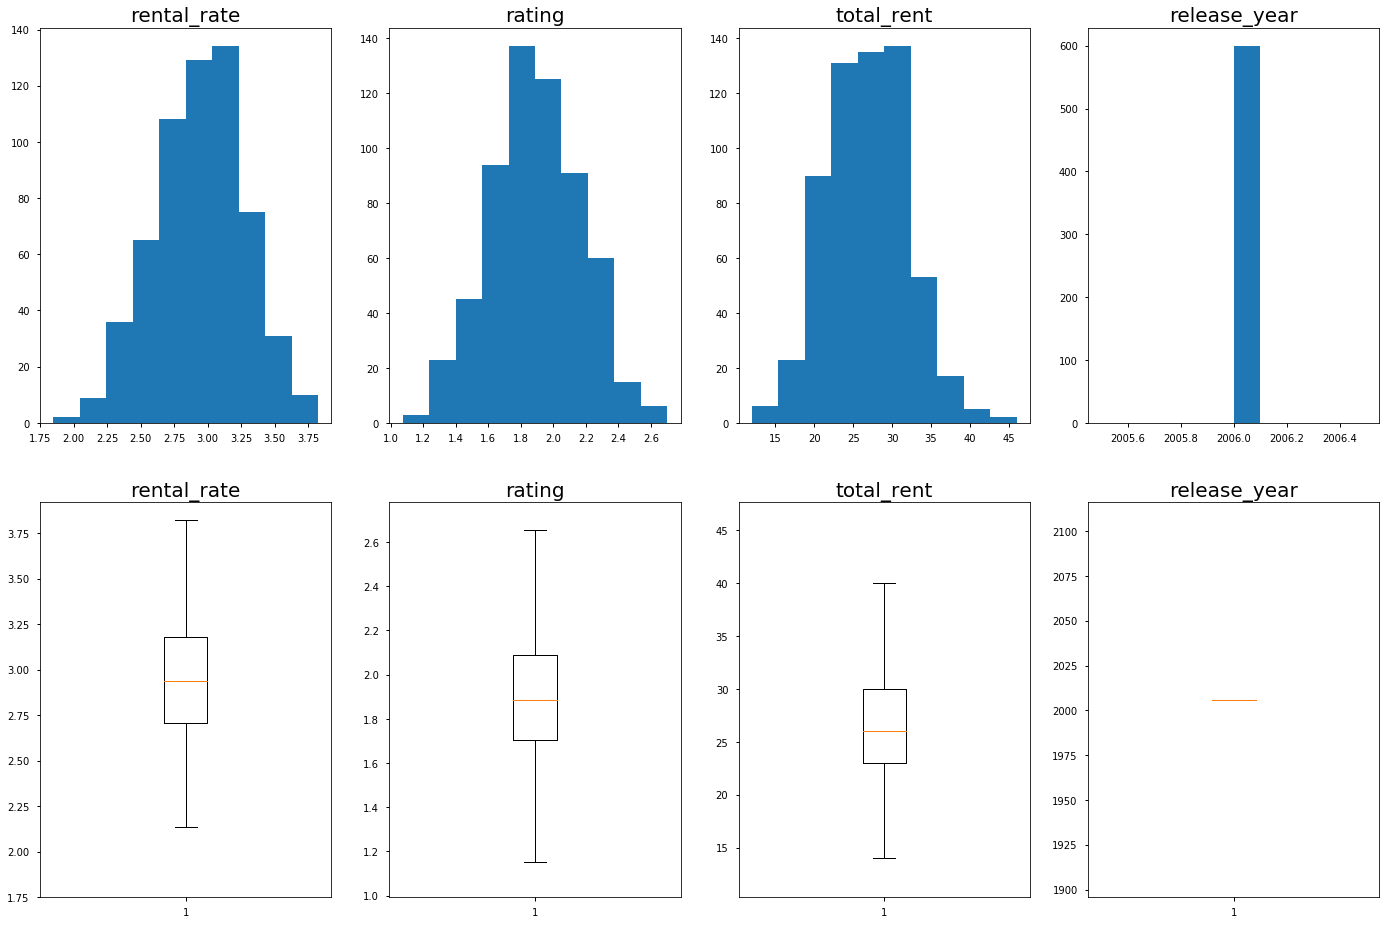

In [87]:
fig=plt.figure(figsize=(24,16))
ax1=fig.add_subplot(241)
ax1.hist(group_data['rental_rate'])
ax1.set_title("rental_rate",fontsize=20)
ax2=fig.add_subplot(242)
ax2.hist(group_data['rating'])
ax2.set_title("rating",fontsize=20)
ax3=fig.add_subplot(243)
ax3.hist(group_data['total_rent'])
ax3.set_title("total_rent",fontsize=20)
ax4=fig.add_subplot(244)
ax4.hist(group_data['release_year'])
ax4.set_title("release_year",fontsize=20)
ax5=fig.add_subplot(245)
ax5.boxplot(group_data['rental_rate'])
ax5.set_title("rental_rate",fontsize=20)
ax6=fig.add_subplot(246)
ax6.boxplot(group_data['rating'])
ax6.set_title("rating",fontsize=20)
ax7=fig.add_subplot(247)
ax7.boxplot(group_data['total_rent'])
ax7.set_title("total_rent",fontsize=20)
ax8=fig.add_subplot(248)
ax8.boxplot(group_data['release_year'])
ax8.set_title("release_year",fontsize=20)

plt.show()

In [88]:
#scaling 
scaler=preprocessing.StandardScaler().fit(group_data)
scaled_data=scaler.transform(group_data)
scaler.mean_
scaled_df = pd.DataFrame(scaled_data, index=group_data.index, columns=group_data.columns)
scaled_df.rename(columns={"title":"total_rent"},inplace=True)

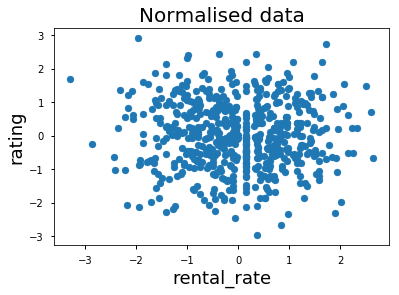

In [89]:
selected_data=scaled_df[['rental_rate','rating']]
plt.scatter(list(selected_data['rental_rate']),list(selected_data['rating']))
plt.xlabel("rental_rate",fontsize=18)
plt.ylabel("rating",fontsize=18)
plt.title("Normalised data",fontsize=20)
plt.show()

In [90]:
#different clusters with rental_rate, rating
selected_data=scaled_df[['rental_rate','rating']]

num_clusters=2
#indices22=np.random.randint(len(selected_data),size=num_clusters)
#centers22=selected_data.iloc[indices,:]
#km22=KMeans(n_clusters=num_clusters,max_iter=50,init=centers,n_init=1)
km22=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km22.fit(selected_data)
predicted_value_22_clusters=km22.predict(selected_data)

num_clusters=3
#indices23=np.random.randint(len(selected_data),size=num_clusters)
#centers23=selected_data.iloc[indices,:]
#km23=KMeans(n_clusters=num_clusters,max_iter=50,init=centers,n_init=1)
km23=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km23.fit(selected_data)
predicted_value_23_clusters=km23.predict(selected_data)

num_clusters=4
#indices24=np.random.randint(len(selected_data),size=num_clusters)
#centers24=selected_data.iloc[indices,:]
#km24=KMeans(n_clusters=num_clusters,max_iter=50,init=centers,n_init=1)
km24=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km24.fit(selected_data)
predicted_value_24_clusters=km24.predict(selected_data)

num_clusters=5
#indices25=np.random.randint(len(selected_data),size=num_clusters)
#centers25=selected_data.iloc[indices,:]
#km25=KMeans(n_clusters=num_clusters,max_iter=50,init=centers,n_init=1)
km25=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km25.fit(selected_data)
predicted_value_25_clusters=km25.predict(selected_data)

selected_data['predicted_22_clusters']=predicted_value_22_clusters
selected_data['predicted_23_clusters']=predicted_value_23_clusters
selected_data['predicted_24_clusters']=predicted_value_24_clusters
selected_data['predicted_25_clusters']=predicted_value_25_clusters


In [91]:
#different clusters with rental_rate, rating,total_rent
selected_data_3=scaled_df[['rental_rate','rating',"total_rent"]]

num_clusters=2
#indices32=np.random.randint(len(selected_data_3),size=num_clusters)
#centers32=selected_data_3.iloc[indices,:]
#km32=KMeans(n_clusters=num_clusters,max_iter=50,init=centers,n_init=1)
km32=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km32.fit(selected_data_3)
predicted_value_32_clusters=km32.predict(selected_data_3)

num_clusters=3
#indices33=np.random.randint(len(selected_data_3),size=num_clusters)
#centers33=selected_data_3.iloc[indices,:]
#km33=KMeans(n_clusters=num_clusters,max_iter=50,init=centers,n_init=1)
km33=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km33.fit(selected_data_3)
predicted_value_33_clusters=km33.predict(selected_data_3)

num_clusters=4
#indices34=np.random.randint(len(selected_data_3),size=num_clusters)
#centers34=selected_data_3.iloc[indices,:]
#km34=KMeans(n_clusters=num_clusters,max_iter=50,init=centers,n_init=1)
km34=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km34.fit(selected_data_3)
predicted_value_34_clusters=km34.predict(selected_data_3)

num_clusters=5
#indices35=np.random.randint(len(selected_data_3),size=num_clusters)
#centers35=selected_data_3.iloc[indices,:]
#km35=KMeans(n_clusters=num_clusters,max_iter=50,init=centers,n_init=1)
km35=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km35.fit(selected_data_3)
predicted_value_35_clusters=km35.predict(selected_data_3)

selected_data_3['predicted_32_clusters']=predicted_value_32_clusters
selected_data_3['predicted_33_clusters']=predicted_value_33_clusters
selected_data_3['predicted_34_clusters']=predicted_value_34_clusters
selected_data_3['predicted_35_clusters']=predicted_value_35_clusters

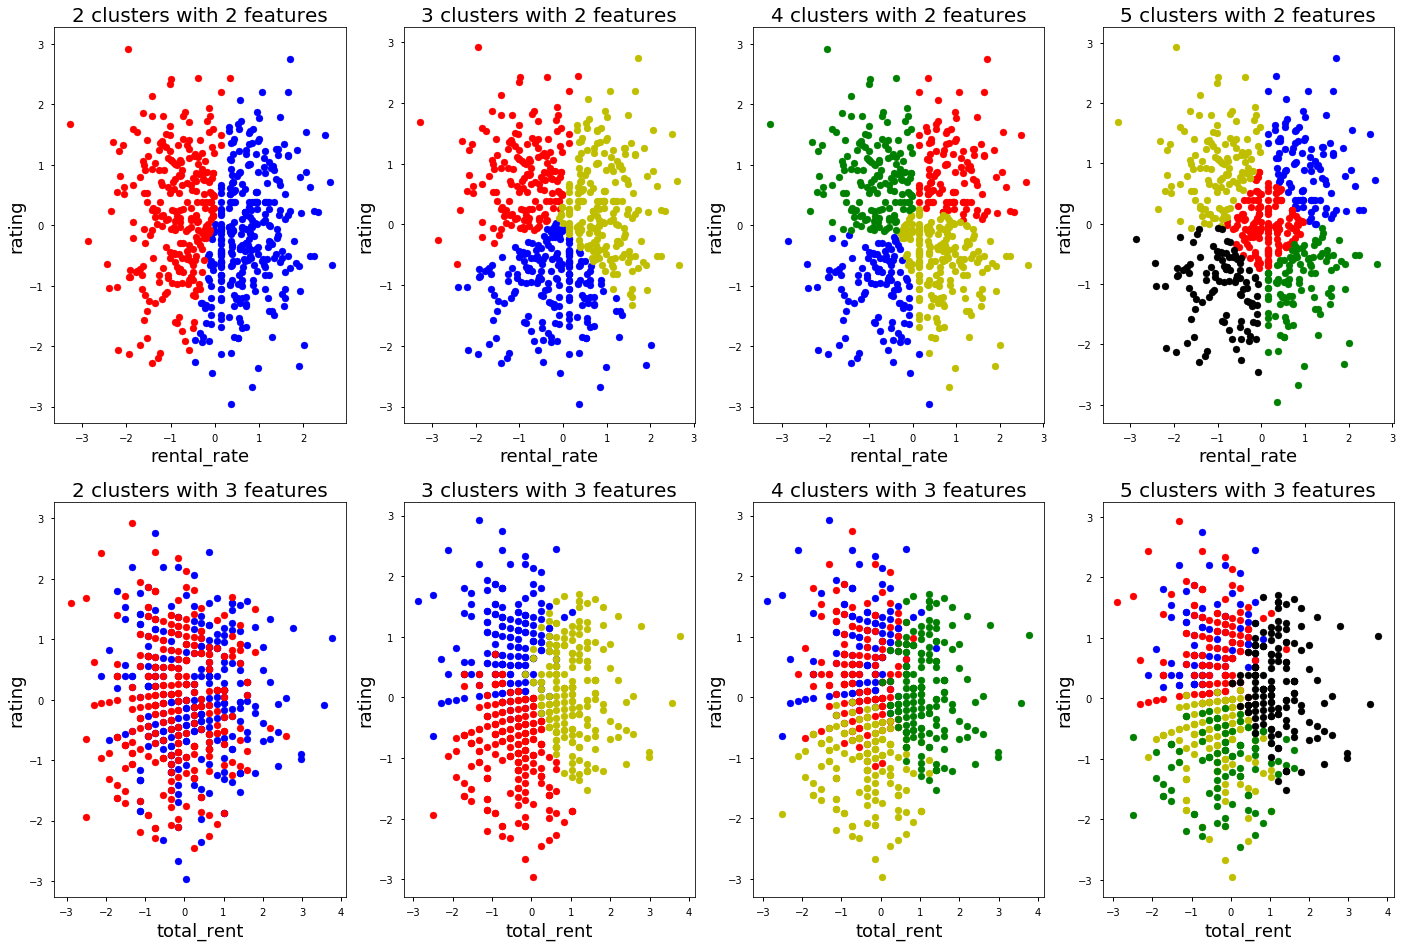

In [92]:
fig=plt.figure(figsize=(24,16))
ax1=fig.add_subplot(241)
group_20=selected_data[selected_data['predicted_22_clusters']==0]
group_21=selected_data[selected_data['predicted_22_clusters']==1]
ax1.scatter(group_20['rental_rate'],group_20['rating'],color='b')
ax1.scatter(group_21['rental_rate'],group_21['rating'],color='r')
ax1.set_xlabel("rental_rate",fontsize=18)
ax1.set_ylabel("rating",fontsize=18)
ax1.set_title("2 clusters with 2 features",fontsize=20)

ax2=fig.add_subplot(242)
group_30=selected_data[selected_data['predicted_23_clusters']==0]
group_31=selected_data[selected_data['predicted_23_clusters']==1]
group_32=selected_data[selected_data['predicted_23_clusters']==2]
ax2.scatter(group_30['rental_rate'],group_30['rating'],color='b')
ax2.scatter(group_31['rental_rate'],group_31['rating'],color='r')
ax2.scatter(group_32['rental_rate'],group_32['rating'],color='y')
ax2.set_xlabel("rental_rate",fontsize=18)
ax2.set_ylabel("rating",fontsize=18)
ax2.set_title("3 clusters with 2 features",fontsize=20)

ax3=fig.add_subplot(243)
group_40=selected_data[selected_data['predicted_24_clusters']==0]
group_41=selected_data[selected_data['predicted_24_clusters']==1]
group_42=selected_data[selected_data['predicted_24_clusters']==2]
group_43=selected_data[selected_data['predicted_24_clusters']==3]
ax3.scatter(group_40['rental_rate'],group_40['rating'],color='b')
ax3.scatter(group_41['rental_rate'],group_41['rating'],color='r')
ax3.scatter(group_42['rental_rate'],group_42['rating'],color='y')
ax3.scatter(group_43['rental_rate'],group_43['rating'],color='g')
ax3.set_xlabel("rental_rate",fontsize=18)
ax3.set_ylabel("rating",fontsize=18)
ax3.set_title("4 clusters with 2 features",fontsize=20)

ax4=fig.add_subplot(244)
group_50=selected_data[selected_data['predicted_25_clusters']==0]
group_51=selected_data[selected_data['predicted_25_clusters']==1]
group_52=selected_data[selected_data['predicted_25_clusters']==2]
group_53=selected_data[selected_data['predicted_25_clusters']==3]
group_54=selected_data[selected_data['predicted_25_clusters']==4]
ax4.scatter(group_50['rental_rate'],group_50['rating'],color='b')
ax4.scatter(group_51['rental_rate'],group_51['rating'],color='r')
ax4.scatter(group_52['rental_rate'],group_52['rating'],color='y')
ax4.scatter(group_53['rental_rate'],group_53['rating'],color='g')
ax4.scatter(group_54['rental_rate'],group_54['rating'],color='black')
ax4.set_xlabel("rental_rate",fontsize=18)
ax4.set_ylabel("rating",fontsize=18)
ax4.set_title("5 clusters with 2 features",fontsize=20)

ax5=fig.add_subplot(245)
group_320=selected_data_3[selected_data_3['predicted_32_clusters']==0]
group_321=selected_data_3[selected_data_3['predicted_32_clusters']==1]
ax5.scatter(group_320['total_rent'],group_320['rating'],color='b')
ax5.scatter(group_321['total_rent'],group_321['rating'],color='r')
ax5.set_xlabel("total_rent",fontsize=18)
ax5.set_ylabel("rating",fontsize=18)
ax5.set_title("2 clusters with 3 features",fontsize=20)

ax6=fig.add_subplot(246)
group_330=selected_data_3[selected_data_3['predicted_33_clusters']==0]
group_331=selected_data_3[selected_data_3['predicted_33_clusters']==1]
group_332=selected_data_3[selected_data_3['predicted_33_clusters']==2]
ax6.scatter(group_330['total_rent'],group_330['rating'],color='b')
ax6.scatter(group_331['total_rent'],group_331['rating'],color='r')
ax6.scatter(group_332['total_rent'],group_332['rating'],color='y')
ax6.set_xlabel("total_rent",fontsize=18)
ax6.set_ylabel("rating",fontsize=18)
ax6.set_title("3 clusters with 3 features",fontsize=20)

ax7=fig.add_subplot(247)
group_340=selected_data_3[selected_data_3['predicted_34_clusters']==0]
group_341=selected_data_3[selected_data_3['predicted_34_clusters']==1]
group_342=selected_data_3[selected_data_3['predicted_34_clusters']==2]
group_343=selected_data_3[selected_data_3['predicted_34_clusters']==3]
ax7.scatter(group_340['total_rent'],group_340['rating'],color='b')
ax7.scatter(group_341['total_rent'],group_341['rating'],color='r')
ax7.scatter(group_342['total_rent'],group_342['rating'],color='y')
ax7.scatter(group_343['total_rent'],group_343['rating'],color='g')
ax7.set_xlabel("total_rent",fontsize=18)
ax7.set_ylabel("rating",fontsize=18)
ax7.set_title("4 clusters with 3 features",fontsize=20)

ax8=fig.add_subplot(248)
group_350=selected_data_3[selected_data_3['predicted_35_clusters']==0]
group_351=selected_data_3[selected_data_3['predicted_35_clusters']==1]
group_352=selected_data_3[selected_data_3['predicted_35_clusters']==2]
group_353=selected_data_3[selected_data_3['predicted_35_clusters']==3]
group_354=selected_data_3[selected_data_3['predicted_35_clusters']==4]
ax8.scatter(group_350['total_rent'],group_350['rating'],color='b')
ax8.scatter(group_351['total_rent'],group_351['rating'],color='r')
ax8.scatter(group_352['total_rent'],group_352['rating'],color='y')
ax8.scatter(group_353['total_rent'],group_353['rating'],color='g')
ax8.scatter(group_354['total_rent'],group_354['rating'],color='black')
ax8.set_xlabel("total_rent",fontsize=18)
ax8.set_ylabel("rating",fontsize=18)
ax8.set_title("5 clusters with 3 features",fontsize=20)

plt.show()

In [93]:
print('The sample size for 2 clusters are:',[len(group_20),len(group_21)])
print('The Sum of squared distances of samples to their closest cluster center is',km22.inertia_)
#print(km2.cluster_centers_)
print('The sample size for 3 clusters are:',[len(group_30),len(group_31),len(group_32)])
print('The Sum of squared distances of samples to their closest cluster center is',km23.inertia_)
#print(km3.cluster_centers_)
print('The sample size for 4 clusters are:',[len(group_40),len(group_41),len(group_42),len(group_43)])
print('The Sum of squared distances of samples to their closest cluster center is',km24.inertia_)
#print(km4.cluster_centers_)
print('The sample size for 5 clusters are:',[len(group_50),len(group_51),len(group_52),len(group_53),len(group_54)])
print('The Sum of squared distances of samples to their closest cluster center is',km25.inertia_)
#print(km5.cluster_centers_)

The sample size for 2 clusters are: [325, 274]
The Sum of squared distances of samples to their closest cluster center is 802.7600737547866
The sample size for 3 clusters are: [209, 167, 223]
The Sum of squared distances of samples to their closest cluster center is 530.6183653077424
The sample size for 4 clusters are: [114, 122, 202, 161]
The Sum of squared distances of samples to their closest cluster center is 409.80675579263834
The sample size for 5 clusters are: [106, 156, 124, 107, 106]
The Sum of squared distances of samples to their closest cluster center is 335.47842306562353


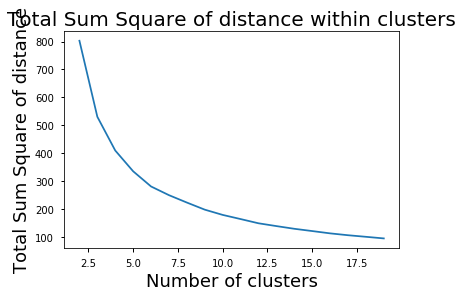

In [94]:
selected_data=scaled_df[['rental_rate','rating']]
ssd_list=[]
x_list=[]
for i in range(2,20):
    num_clusters=i
    #indices=np.random.randint(len(selected_data),size=num_clusters)
    #centers=selected_data.iloc[indices,:]
    km=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
    km.fit(selected_data)
    x_list.append(i)
    ssd_list.append(km.inertia_)

plt.plot(x_list,ssd_list)
plt.title("Total Sum Square of distance within clusters",fontsize=20)
plt.xlabel("Number of clusters",fontsize=18)
plt.ylabel("Total Sum Square of distance",fontsize=18)
plt.show()

<span style="color:blue">
    
###  Firstly,I created a variable called total_rent which represents the total number of film rented by each customer. Given by question,  there are only four useful features including rating, rental_rate,release_year and total_rent. The histogram and boxplot shows rating, rental_rate and total_rent varies according to different customers while release_year remains stable. This means release_year is not useful here, so I remove the variable releas_year.Next,I normalise the features as scalling is important to k-means clustering because we use Euclidean distance as measures. I use two featureas including rating and rental_rate and three features including rating, rental_rate and total_rent to implement k-means clustering where k is 2,3,4,5. In the plot, the first rwo shows the clustering result is good and have no overlap between each clusters while the second row shows the clustering result is bad and feature total_rent is not helpful in clustering as there are many overlaps. So I choose two features rating and rental_rate. 

###  Finally I choose result with four clusters based on features rating and rental_rate. The first reason is the plot shows the 4 clustering have clear boundaries and no overlap, also the size and the shape in each cluster is roughly same. Another reason is tightness. The last line plot shows as k increase, the distance in same cluster decrease, and it will decrease to zero especially when we put each single data in one cluster. But this cause "overfitting" problem. Actually we want the small k with relatively small sum square distance. In this case, 4 clusters have a resonable small sum square distance. When I implement k-means clustering, I set max_iter=50,init='k-means++',n_init=300. Because ususally the algorithm converge after 20-50 iterations, so here I choose the maximum number 50 to ensure the algorithm converge. The setting init='k-means++',n_init=300 can reduce the impact of initialization and the result are more stable.   
</span>

**

#### Explain the distinguishing characteristics of each cluster. 
<span style= 'float: right;'><b></b></span>

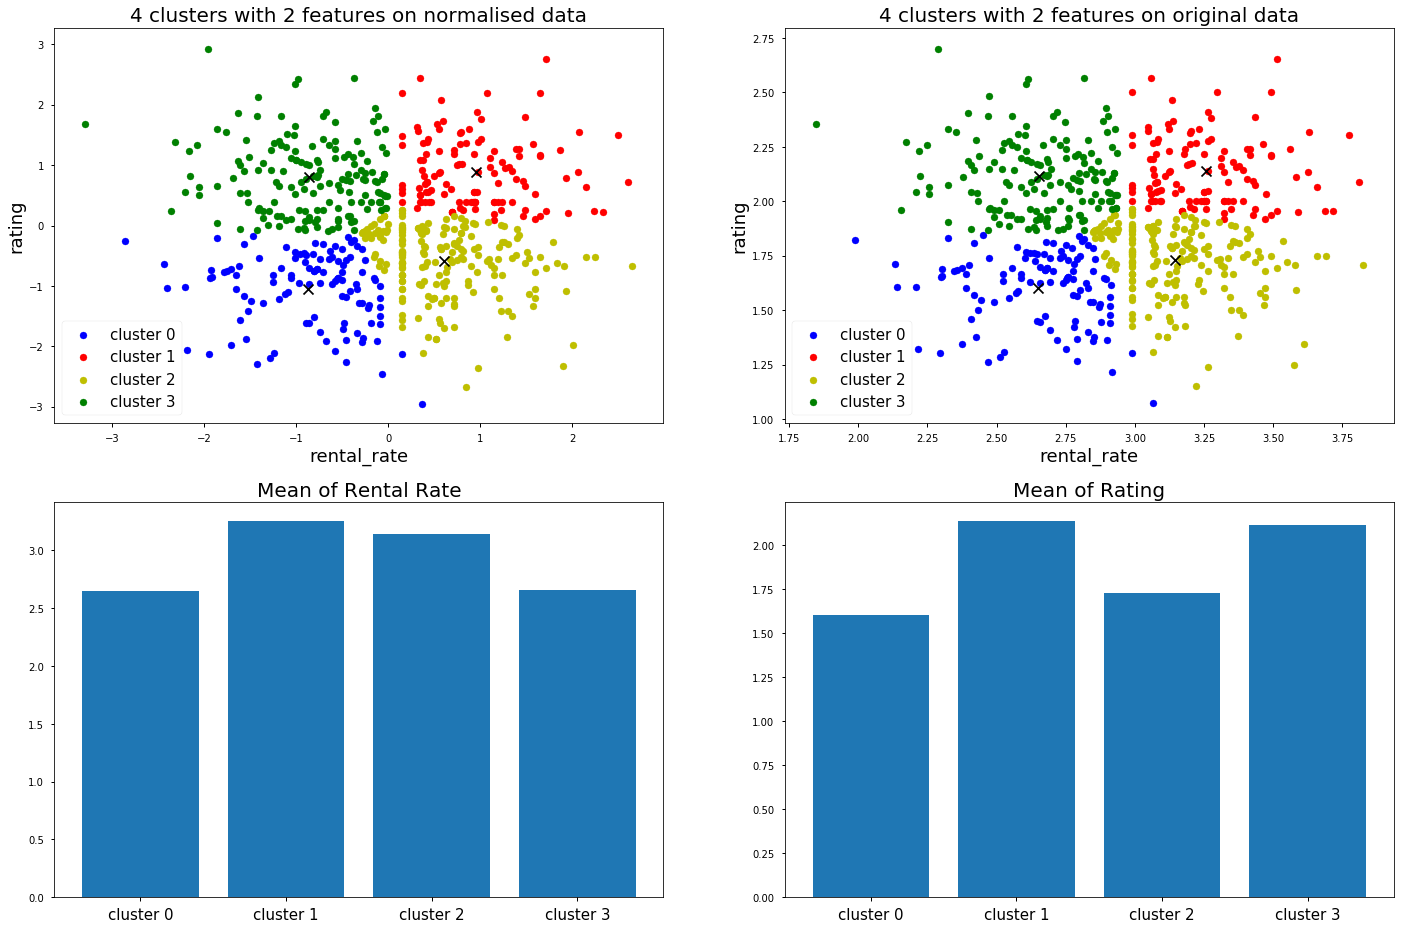

                      rental_rate    rating
predicted_4_clusters                       
0                        2.651120  1.601610
1                        3.256870  2.138844
2                        3.143084  1.729896
3                        2.653857  2.114549


In [96]:
#cluster4 statistical analysis
x_index=list(range(4))
selected_data['predicted_24_clusters']=predicted_value_24_clusters
group_data['predicted_4_clusters']=predicted_value_24_clusters
groupdata_4clusters=group_data.groupby('predicted_4_clusters').agg({'rental_rate':'mean','rating':'mean'})

fig=plt.figure(figsize=(24,16))
ax1=fig.add_subplot(221)
group_40=selected_data[selected_data['predicted_24_clusters']==0]
group_41=selected_data[selected_data['predicted_24_clusters']==1]
group_42=selected_data[selected_data['predicted_24_clusters']==2]
group_43=selected_data[selected_data['predicted_24_clusters']==3]
ax1.scatter(group_40['rental_rate'],group_40['rating'],color='b',label='cluster 0')
ax1.scatter(group_41['rental_rate'],group_41['rating'],color='r',label='cluster 1')
ax1.scatter(group_42['rental_rate'],group_42['rating'],color='y',label='cluster 2')
ax1.scatter(group_43['rental_rate'],group_43['rating'],color='g',label='cluster 3')
ax1.scatter(km24.cluster_centers_[:,0],km24.cluster_centers_[:,1],marker='x',color='black',s=100)
ax1.set_xlabel("rental_rate",fontsize=18)
ax1.set_ylabel("rating",fontsize=18)
ax1.set_title("4 clusters with 2 features on normalised data",fontsize=20)
ax1.legend(fontsize=15)

ax2=fig.add_subplot(222)
group_040=group_data[group_data['predicted_4_clusters']==0]
group_041=group_data[group_data['predicted_4_clusters']==1]
group_042=group_data[group_data['predicted_4_clusters']==2]
group_043=group_data[group_data['predicted_4_clusters']==3]
ax2.scatter(group_040['rental_rate'],group_040['rating'],color='b',label='cluster 0')
ax2.scatter(group_041['rental_rate'],group_041['rating'],color='r',label='cluster 1')
ax2.scatter(group_042['rental_rate'],group_042['rating'],color='y',label='cluster 2')
ax2.scatter(group_043['rental_rate'],group_043['rating'],color='g',label='cluster 3')
ax2.scatter(list(groupdata_4clusters['rental_rate']),list(groupdata_4clusters['rating']),marker='x',color='black',s=100)
ax2.set_xlabel("rental_rate",fontsize=18)
ax2.set_ylabel("rating",fontsize=18)
ax2.set_title("4 clusters with 2 features on original data",fontsize=20)
ax2.legend(fontsize=15)

ax3=fig.add_subplot(223)
ax3.bar(x_index,groupdata_4clusters['rental_rate'])
ax3.set_title("Mean of Rental Rate",fontsize=20)
ax3.set_xticks(x_index)
ax3.set_xticklabels(['cluster 0','cluster 1','cluster 2','cluster 3'],fontsize=15)

ax4=fig.add_subplot(224)
ax4.bar(x_index,groupdata_4clusters['rating'])
ax4.set_title("Mean of Rating",fontsize=20)
ax4.set_xticks(x_index)
ax4.set_xticklabels(['cluster 0','cluster 1','cluster 2','cluster 3'],fontsize=15)

plt.show()
pd_original=pd.DataFrame(groupdata_4clusters)
pd_normalised=pd.DataFrame(km24.cluster_centers_,columns=['rental rate','rating'])
print(pd_original)


|Cluster|Rental rate|Rating        
|:---:|:--:|:--:|
|cluster 0|low|low     
|cluster 1|high|high 
|cluster 2|high|low 
|cluster 3|low|high 

<span style="color:blue">
    
###  From the plot, there are four distinct clusters with different centroids. 
### The cluster 0 represents by blue, has low rental_rate and low rating. This means the customers in this group prefer rent the movie with low rental_rate such as 0.99  and low rating such as PG-13 or NC-17. 
### The cluster 1 represents by red, has high rental_rate and high rating. This means the customers in this group prefer rent the movie with high rental_rate such as 2.99 or 4.99 and high rating such as PG, R or G.
### The cluster 2 represents by yellow, has high rental_rate and low rating. This means the customers in this group prefer rent the movie with high rental_rate such as 2.99 or 4.99 and low rating such as PG-13 or NC-17.
### The cluster 3 represents by green, has low rental_rate and high rating. This means the customers in this group prefer rent the movie with low rental_rate such as 0.99 and high rating such as PG, R or G.

</span>

**

***

### Classification 

The rental company has decided that they want to use simple machine learning to allocate price tags to their movies. The tags are as follows:


|  **Classification**      |  **Requirements**        |
|--------------------------|------------------------- |
|  Cheap                   |  Rental Rate is 0.99   |
|  Moderate                |  Rental Rate is 2.99   |
|  Expensive               |  Rental Rate is 4.99  |


**The task is to implement a `Classification Algorithm` (such as K-Nearest Neighbours) that can predict the `Price Label` of a movie**. The process include:

1. Create useable dataset/s by manually determining the 'truth values' for existing data (where the rating is within the classification system defined above)
2. Implement an algorithm that can predict the classification as per the above classifications.
3. Perform independent testing of the model and provide statistical metrics outlining the performance of your model. Splitting the dataset into testing and training subsets will assist with this.

In [8]:
# YOUR CODE HERE
#prepare data
price_tag=[]
for number in merge26['rental_rate']:
    if number==0.99:
        price_tag.append(0)
    elif number ==2.99:
        price_tag.append(1)
    else:
        price_tag.append(2)
merge26['price_tag']=price_tag
replacement_item={'PG-13':0,'NC-17':1,'PG':2,'R':3,'G':4}
data22=merge26.replace(replacement_item)
data22.rename(columns={'name':"category"},inplace=True)
labelEncoder=preprocessing.LabelEncoder()
labelEncoder.fit(data22['category'])
data22['category']=labelEncoder.transform(data22['category'])
sub_data=data22

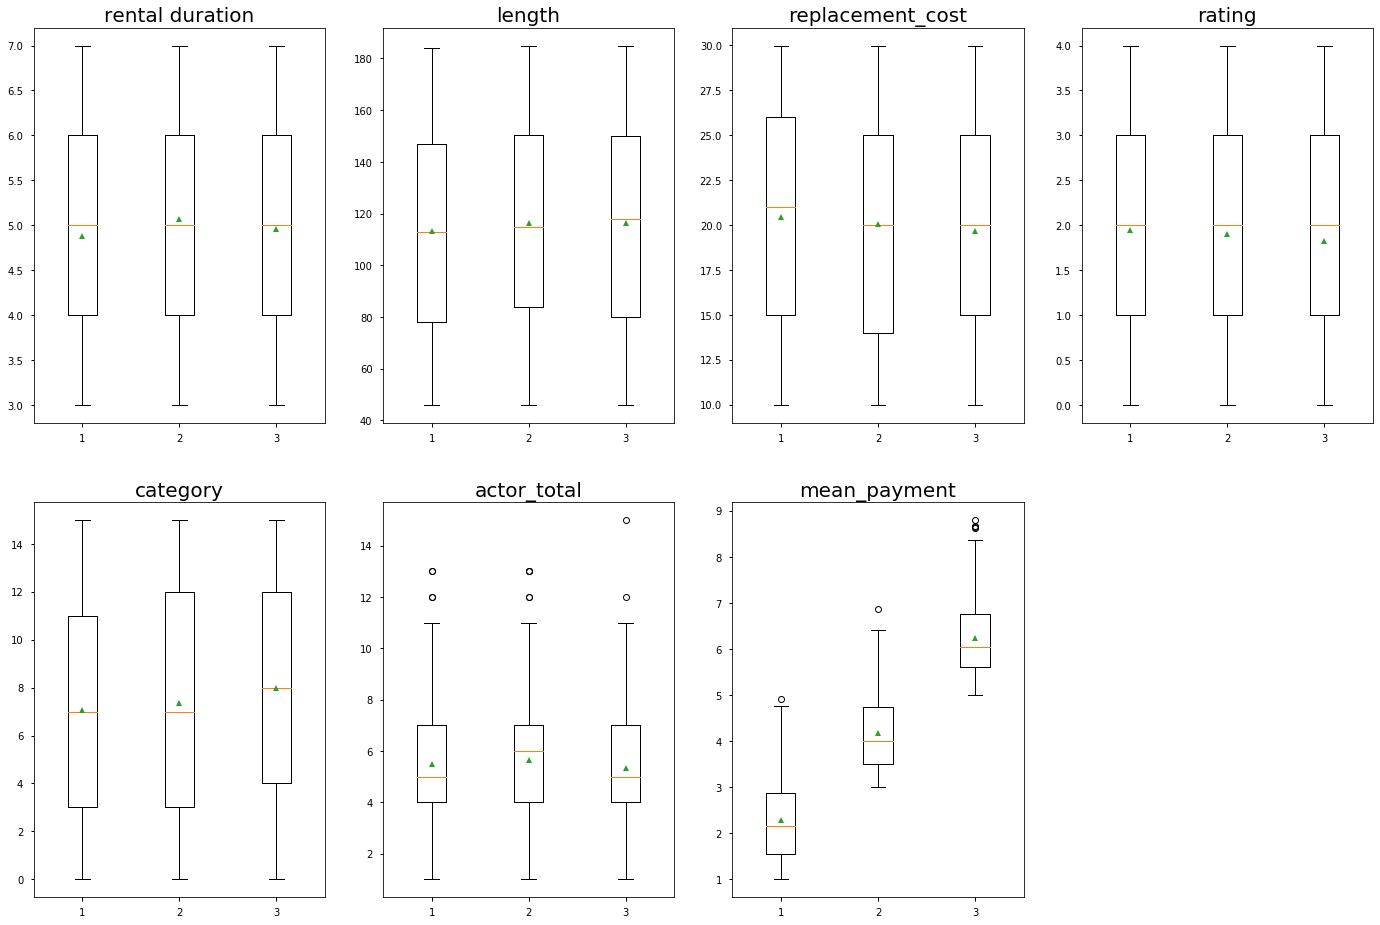

mean


,rental_duration,length,replacement_cost,rating,category_id,category,mean_payment,actor_total
price_tag,,,,,,,,
0,4.876923,113.332308,20.436154,1.947692,8.049231,7.049231,2.273610,5.501538
1,5.067308,116.320513,20.044487,1.907051,8.371795,7.371795,4.166597,5.663462
2,4.962264,116.500000,19.666101,1.827044,8.996855,7.996855,6.241306,5.317610


standard error


,rental_duration,length,replacement_cost,rating,category_id,category,mean_payment,actor_total
price_tag,,,,,,,,
0,1.417567,40.823397,6.139909,1.414334,4.543077,4.543077,0.848151,2.318238
1,1.436307,40.009884,6.099411,1.425880,4.711917,4.711917,0.830048,2.398863
2,1.359100,40.485208,5.925840,1.406931,4.543167,4.543167,0.820780,2.213325


sample size


,rental_duration,length,replacement_cost,rating,category_id,category,mean_payment,actor_total
price_tag,,,,,,,,
0,325,325,325,325,325,325,325,325
1,312,312,312,312,312,312,312,312
2,318,318,318,318,318,318,318,318


In [9]:
price_0=sub_data[sub_data['price_tag']==0]
price_1=sub_data[sub_data['price_tag']==1]
price_2=sub_data[sub_data['price_tag']==2]

fig=plt.figure(figsize=(24,16))
ax1=fig.add_subplot(241)
ax1.boxplot([list(price_0['rental_duration']),list(price_1['rental_duration']),list(price_2['rental_duration'])],showmeans=True)
ax1.set_title("rental duration",fontsize=20)

ax2=fig.add_subplot(242)
ax2.boxplot([list(price_0['length']),list(price_1['length']),list(price_2['length'])],showmeans=True)
ax2.set_title("length",fontsize=20)

ax3=fig.add_subplot(243)
ax3.boxplot([list(price_0['replacement_cost']),list(price_1['replacement_cost']),list(price_2['replacement_cost'])],showmeans=True)
ax3.set_title("replacement_cost",fontsize=20)

ax4=fig.add_subplot(244)
ax4.boxplot([list(price_0['rating']),list(price_1['rating']),list(price_2['rating'])],showmeans=True)
ax4.set_title("rating",fontsize=20)

ax5=fig.add_subplot(245)
ax5.boxplot([list(price_0['category']),list(price_1['category']),list(price_2['category'])],showmeans=True)
ax5.set_title("category",fontsize=20)

ax6=fig.add_subplot(246)
ax6.boxplot([list(price_0['actor_total']),list(price_1['actor_total']),list(price_2['actor_total'])],showmeans=True)
ax6.set_title("actor_total",fontsize=20)

ax7=fig.add_subplot(247)
ax7.boxplot([list(price_0['mean_payment']),list(price_1['mean_payment']),list(price_2['mean_payment'])],showmeans=True)
ax7.set_title("mean_payment",fontsize=20)
plt.show()

sub_data=data22.drop(['film_id','rental_rate'],axis=1)
pd1=sub_data.groupby('price_tag').mean()
pd2=sub_data.groupby('price_tag').std()
pd3=sub_data.groupby('price_tag').count()
print("mean")
display(pd1)
print("standard error")
display(pd2)
print("sample size")
display(pd3)


<span style="color:blue">

###   After import data from database, We transfer the category variable into numeric variable and change some column name to make data clear and easy to understand. Also, We create two variables actor_total which represents the total number of actors in each movie and mean_payment which means the mean rental payment for each movie.  Then, We split each variable by rental_rate and check the data distribution. The box plots shows the distributions of rental_duration,length,replacement_cost and rating are very similar but category,actor_total and mean_payment have a different distributions in each rental_rate category. Also three tables shows the standard errors and sample sizes are roughly equal, which means our result from boxplot is valid. In addition, we also find there is relationship between rental_rate and rating in k-means clustering.So, in this case, I select variable category, actor_total, mean_payment and rating to implement knn because its useful to distinguish different rental_rate.

</span>   

In [10]:
#select attributes and scalling data
selected_data2=data22[['actor_total','category','mean_payment','rating','price_tag']]
original_x=selected_data2.drop('price_tag',axis=1)
y=selected_data2['price_tag']

scaler2=preprocessing.StandardScaler().fit(original_x)
scaled_data2=scaler2.transform(original_x)
x = pd.DataFrame(scaled_data2, index=original_x.index, columns=original_x.columns)

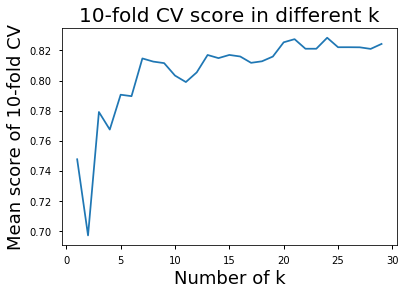

The biggest score is  0.8283298314881303  , and the k value is  24


In [11]:
accuracy_score=[]
for k in range(1,int(math.sqrt(len(x)))):
    knn_classifier=KNeighborsClassifier(n_neighbors=k)
    knn_score=cross_val_score(knn_classifier,x,y,cv=10)
    accuracy_score.append([k,np.mean(knn_score)])

x1,y1=zip(*accuracy_score)
plt.plot(x1,y1)
plt.title("10-fold CV score in different k",fontsize=20)
plt.xlabel("Number of k",fontsize=18)
plt.ylabel("Mean score of 10-fold CV",fontsize=18)
plt.show()
best_k=y1.index(max(y1))+1
print('The biggest score is ',max(y1),' , and the k value is ',best_k)

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
k4_classifier=KNeighborsClassifier(n_neighbors=best_k)
k4_classifier.fit(x_train,y_train)
y_prediction=k4_classifier.predict(x_test)

prfs=np.round(skm.precision_recall_fscore_support(y_test,y_prediction),4)
loss01=skm.zero_one_loss(y_test,y_prediction)
accuracy=skm.accuracy_score(y_test,y_prediction)
cmat=skm.confusion_matrix(y_test,y_prediction)
print(cmat)
#print(loss01)
print("accuracy rate",accuracy)
print('Precision for each cluster are',prfs[0])
print('Recall for each cluster are',prfs[1])
print('F1 score for each cluster are',prfs[2])

[[49  9  0]
 [ 9 52 11]
 [ 0  4 57]]
accuracy rate 0.8272251308900523
Precision for each cluster are [0.8448 0.8    0.8382]
Recall for each cluster are [0.8448 0.7222 0.9344]
F1 score for each cluster are [0.8448 0.7591 0.8837]


<span style="color:blue">
    
###    Before implementing knn algorithm, the data need to be scalled because here we use Euclidean distance as measures and knn algorithm is sensitive to different scale. When we choose hyperparameter k, we use 10-fold cross validation because the result is more stable. The plot above shows the result of the best k with the biggest accuracy score. Finally, we split data into training data(80%) and test data(20%) and implement knn with best k parameter. The output shows the resuts on test data such as metrics, accuracy rate, precision, recall and f1 score for each rental_rate category. This result should not be exactly same at every time as we randomly split training and testing data. But results should be similar and we can see the accuracy rate is above 80%, precision and recall are above 0.8 which are very high. F1 score for each rental_rate(price_label) are very high as well, this means precision and recall are equally important. All the metrics and validation results shows the model have a good prediction. 
###    Strength and pitfall: strength includes knn is easy to understand and implement, no assumption for model, many choices for distance meansure based on different purpose. On the other hand, some pitfalls alse associated with knn. First one is curse of dimensionality. As we use more features in knn, the data size the knn need will increase exponentially. We need to be very careful to select the number of features considering data size. In this case we have four features. The second problem is chosing optimal hyperparameter k. Many factors could influence the result of k such as the different features and different distance measure. Also, knn is not good for large data as computation complexity. knn calculate every distance in data and it will be time consuming when data is large. Scalling is important in knn as distance measure is sensitative to scales. Finally, knn is not robust to outliers. One single large point could change the result of knn. 
    
</span>

**

#### Check result when using Clustering as a pre-processing step before Classfication

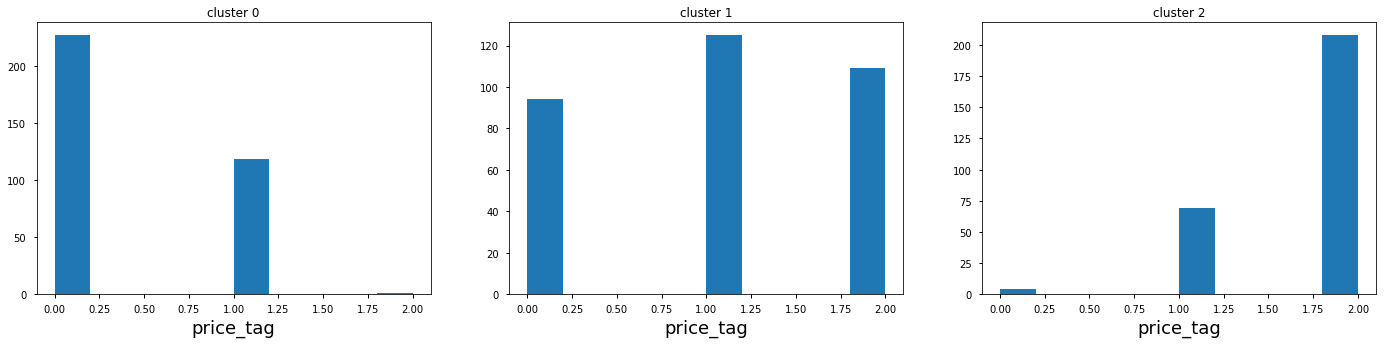

In [102]:
num_clusters=3
km_2=KMeans(n_clusters=num_clusters,max_iter=50,init='k-means++',n_init=300)
km_2.fit(x)
clusters=km_2.predict(x)
pd_clusters=pd.DataFrame({'price_tag':y,'clusters':clusters})
clusters_0=pd_clusters[pd_clusters['clusters']==0]['price_tag']
clusters_1=pd_clusters[pd_clusters['clusters']==1]['price_tag']
clusters_2=pd_clusters[pd_clusters['clusters']==2]['price_tag']

fig=plt.figure(figsize=(24,5))
ax1=fig.add_subplot(131)
ax1.hist(clusters_0)
ax1.set_title("cluster 0")
ax1.set_xlabel("price_tag",fontsize=18)
ax2=fig.add_subplot(132)
ax2.hist(clusters_1)
ax2.set_title("cluster 1")
ax2.set_xlabel("price_tag",fontsize=18)
ax3=fig.add_subplot(133)
ax3.hist(clusters_2)
ax3.set_title("cluster 2")
ax3.set_xlabel("price_tag",fontsize=18)
plt.show()

<span style="color:blue">
    
###    In this case, I would like to say clustering is helpful for classification and we will be able to get a better result.The reason is clustering is unsupervised and it help us find intrinsic structure that exists in features without considering label. And this potential structure may explain the difference in label and hence it is useful in classification. For example, in this case, we try three clusters on features and check the relationship between clustering and classification. The plot shows in different clusters, the distribution of label(price_tag) is different especially in cluster 0 and cluster 2. In cluster 0, the majority of price_tag is 2 but in cluster 2, the majority price_tag is 0. Apparently, clustering has significant impact on classification.     
</span>

**

***

## Decision Trees 

The following is a small synthetic data set about the weather conditions.  We are
going to try and use decision trees to predict whether it will rain or not on the given day.


|Temperature| Cloudy| UV Index| Humidity| Rain
|---:|--:|--:|--:|--:|
|25|No| Low| Low| No 
|29|No| Low| High| No
|26|No| Low| Medium| No
|26|No| Medium| Medium| No
|27|No| Medium| High| No
|28|No| High | High| No
|25|No| High |Low| No
|29|Yes| Low |Low| Yes
|28|No| Medium| High| Yes
|28|Yes| Medium| High| Yes
|26|No| Low |Low| Yes
|27|Yes| Low |High| Yes

**Note:**
* You can treat temperature as a continuous variable and split it on a range of values (to convert it to a categorical variable, for example).
* Attribute selection in the tree uses information gain.

In [9]:
temp=[0,1,0,0,1,1,0,1,1,1,0,1]
cloudy=[0,0,0,0,0,0,0,1,0,1,0,1]
uv=[0,0,0,1,1,2,2,0,2,2,0,0]
humidity=[0,2,1,1,2,2,0,0,2,2,0,2]
rain=[0,0,0,0,0,0,0,1,1,1,1,1]
data4=pd.DataFrame({"temp":temp,"cloudy":cloudy,"uv":uv,"humidity":humidity,"rain":rain})
x4=data4.drop(['rain'],axis=1)
y4=data4['rain']
data4

,temp,cloudy,uv,humidity,rain
0,0,0,0,0,0
1,1,0,0,2,0
2,0,0,0,1,0
3,0,0,1,1,0
4,1,0,1,2,0
5,1,0,2,2,0
6,0,0,2,0,0
7,1,1,0,0,1
8,1,0,2,2,1
9,1,1,2,2,1


In [11]:
dt=DecisionTreeClassifier(criterion="entropy",presort=True)
dt.fit(x4,y4)
applied=dt.apply(x4)
dotf=export_graphviz(dt,"decision_tree.dot")

<span style="color:blue">

### We treat temperature as 0 if it is smaller or equal to 26 and treat it as 1 if it is greater than 26 because this is easy to implement decision tree. The tables below shows the frequency of each variable to rain. This will help us calculate entropy and information gain in questions. 

</span>

|Cloudy|Rain=0|Rain=1        
|:---:|:--:|:--:|
|No(0)|7|2     
|Yes(1)|0|3  

|UV Index|Rain=0|Rain=1
|:---:|:--:|:--:|
|Low(0)|3|3     
|Medium(1)|2|0
|High(2)|2|2

|Humidity|Rain=0|Rain=1
|:---:|:--:|:--:|
|Low(0)|2|2     
|Medium(1)|2|0
|High(2)|3|3

|Temperature|Rain=0|Rain=1        
|:---:|:--:|:--:|
|<=26(0)|4|1     
|>26(1)|3|4  





#### 1. Calculate the initial entropy of Cloudy.

In [68]:
#for temperature divided into below include 26 and above 26
print('cloudy entropy',np.round(-((3/12)*math.log(3/12,2)+(9/12)*math.log(9/12,2)),5))
print('temp entropy',np.round(-((5/12)*math.log(5/12,2)+(7/12)*math.log(7/12,2)),5))
print('uv index entropy',np.round(-((6/12)*math.log(6/12,2)+(4/12)*math.log(4/12,2)+(2/12)*math.log(2/12,2)),5))
print('humidity',np.round(-((4/12)*math.log(4/12,2)+(2/12)*math.log(2/12,2)+(6/12)*math.log(6/12,2)),5))
print('rain entropy',np.round(-((7/12)*math.log(7/12,2)+(5/12)*math.log(5/12,2)),5))

cloudy entropy 0.81128
temp entropy 0.97987
uv index entropy 1.45915
humidity 1.45915
rain entropy 0.97987


<span style="color:blue">
   
###    The initial entropy of cloudy is $$H(cloudy)=-(\frac{3}{12}*log_2\frac{3}{12}+\frac{9}{12}*log_2\frac{9}{12})= 0.81128 $$ 
</span>

#### 2. Determine the attribute would the decision-tree building algorithm choose at the root of the tree.

In [69]:
#entropy of rain
H_rain=-((7/12)*math.log(7/12,2)+(5/12)*math.log(5/12,2))
print("Entropy of rain is",np.round(H_rain,4))

temp_a=np.round(-((4/5)*math.log(4/5,2)+(1/5)*math.log(1/5,2)),5)
temp_b=np.round(-((3/7)*math.log(3/7,2)+(4/7)*math.log(4/7,2)),5)
H_temp=5/12*temp_a+7/12*temp_b
print('Temp information gain is',np.round(H_rain-H_temp,4))

cloud_a=np.round(-((7/9)*math.log(7/9,2)+(2/9)*math.log(2/9,2)),5)
H_cloudy=9/12*cloud_a
print('Cloudy information gain is',np.round(H_rain-H_cloudy,4))

#uv info gain
uv_a=np.round(-((3/6)*math.log(3/6,2)+(3/6)*math.log(3/6,2)),5)
uv_b=np.round(-((2/4)*math.log(2/4,2)+(2/4)*math.log(2/4,2)),5)
H_uv=6/12*uv_a+4/12*uv_b
print('UV index information gain is',np.round(H_rain-H_uv,4))

#humidity info gain
hum_a=np.round(-((3/6)*math.log(3/6,2)+(3/6)*math.log(3/6,2)),5)
hum_b=np.round(-((2/4)*math.log(2/4,2)+(2/4)*math.log(2/4,2)),5)
H_hum=6/12*hum_a+4/12*hum_b
print('Humidity information gain is',np.round(H_rain-H_hum,4))




Entropy of rain is 0.9799
Temp information gain is 0.1043
Cloudy information gain is 0.4067
UV index information gain is 0.1465
Humidity information gain is 0.1465


<span style="color:blue">
    
### The variable Cloudy would be chosen at the root of the tree because it has the highest information gain 0.4067. This result is same as decision tree picture within the file.  (Calculation process are provided by the next question, and for other variables, the calculations of information gain are similar. ) 
</span>

#### 3. Calculate and specify the information gain of the attribute you chose to split on in the previous step

<span style="color:blue">
    

####    The entropy of Rain is $$H(Rain)=-(P(Rain=0)*log_2 P(Rain=0)+P(Rain=1)*log_2 P(Rain=1))=-(\frac{7}{12}*log_2 \frac{7}{12}+\frac{5}{12}*log_2 \frac{5}{12})=0.9799 $$ 

#### <span style="color:blue"> The entropy of Rain depend on Cloudy is 
$$ H(Rain|Cloudy)=P(Cloudy=0)*H(Rain|Cloudy=0)+P(Cloudy=1)*H(Rain|Cloudy=1) $$ where $$ H(Rain|Cloudy=0)=-(P(Rain=0|Cloudy=0)*log_2 P(Rain=0|Cloudy=0)+P(Rain=1|Cloudy=0)*log_2 P(Rain=1|Cloudy=0))$$
#### <span style="color:blue"> and $$ H(Rain|Cloudy=1)=-(P(Rain=0|Cloudy=1)*log_2 P(Rain=0|Cloudy=1)+P(Rain=1|Cloudy=1)*log_2 P(Rain=1|Cloudy=1)) $$
#### <span style="color:blue"> Also, $$ P(Rain=0|Cloudy=0)=\frac{P(Rain=0,Cloudy=0)}{P(Cloudy=0)} $$ 
#### <span style="color:blue"> this is similar for $$ P(Rain=0|Cloudy=1),P(Rain=1|Cloudy=0),P(Rain=1|Cloudy=1)$$

#### <span style="color:blue"> From the table, we can calculate $$H(Rain|Cloudy=0)=-(\frac{7}{9}*log_2\frac{7}{9}+\frac{2}{9}*log_2\frac{2}{9})=0.7642 $$
#### <span style="color:blue"> and  $$H(Rain|Cloudy=1)=0 $$
#### <span style="color:blue"> so $$H(Rain|Cloudy)= \frac{9}{12}*0.7642+0=0.57315$$
#### <span style="color:blue"> The information gain is $$IG(Rain|Cloudy)=H(Rain)-H(Rain|Cloudy)=0.9799-0.57315=0.4067$$


</span>